## Introduction to Data Science

### Graph Analysis

Based on the experiment reported at http://www.coppelia.io/2012/06/graphing-the-history-of-philosophy/ and information crawled from wikipedia:

Our task is to answer the questions:  

 1) What are the top 10 personalities in terms of power to generate influences?  
 2) What are the 10 personalities that were influenced by the most number of people?  
 3) What are the 5 major "clusters" of personalities who were influenced by a similar group of the same influencers?   
(Consider a cluster as the group of personalities who were influenced by the same Y influencers, Y being an arbitrary number. Start with Y = 2 and grow until there is no 2 people influenced by all of them.  

 4) What are the 5 major influences chains (eg, A -> B -> C -> ...)?  
 5) What are the countries that generated the greatest influential?  
 6) What are the areas of greatest influence?  
 7) Create a graphical representation of the graph  

Importing modules

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import pylab as pl
import pandas as pd
import networkx as nx
import codecs
from collections import Counter, OrderedDict
import os
import operator

import urllib
from bs4 import BeautifulSoup
import pydot

%matplotlib inline

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/dist-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['source']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


Specifying the path to the files:

In [2]:
datapath = "../datasets/CSVs/"
outputs = "../outputs/"
dataset1 = "influences.csv"

#### Loading the dataset

In [3]:
csvfile = codecs.open(os.path.join(datapath,dataset1), encoding="utf-8").readlines()

In [4]:
csvfile[0:5]

['"Influences","Influenced"\n',
 '"Ferdinand de Saussure","Jacques Lacan"\n',
 '"Georg Wilhelm Friedrich Hegel","Jacques Lacan"\n',
 '"Sigmund Freud","Jacques Lacan "\n',
 '"Benjamin Tucker","Robert Anton Wilson "\n']

#### Doing some cleaning  

In [5]:
lines = [line.strip() for line in csvfile]
lines2 = []
for line in lines:
    line = line.replace('",','";')
    line = line.replace('"','').strip()
    lines2.append(line)
for line in lines2[0:6]:
    print(line)

Influences;Influenced
Ferdinand de Saussure;Jacques Lacan
Georg Wilhelm Friedrich Hegel;Jacques Lacan
Sigmund Freud;Jacques Lacan
Benjamin Tucker;Robert Anton Wilson
Brian O'Nolan;Robert Anton Wilson


In [6]:
influences = np.array([(line.split(';')[0],line.split(';')[1]) for line in lines2])
print('Dimensions: {}'.format(influences.shape))
influences[:10]

Dimensions: (5009, 2)


array([['Influences', 'Influenced'],
       ['Ferdinand de Saussure', 'Jacques Lacan'],
       ['Georg Wilhelm Friedrich Hegel', 'Jacques Lacan'],
       ['Sigmund Freud', 'Jacques Lacan'],
       ['Benjamin Tucker', 'Robert Anton Wilson'],
       ["Brian O'Nolan", 'Robert Anton Wilson'],
       ['Terence McKenna', 'Robert Anton Wilson'],
       ['Colin Wilson', 'Robert Anton Wilson'],
       ['Robert W. Chambers', 'Robert Anton Wilson'],
       ['Aristotle', 'Alexander the Great']], dtype='<U52')

In [7]:
pd_influences = pd.DataFrame(influences[1:,:], columns = influences[0])
pd_influences.head(10)

,Influences,Influenced
0,Ferdinand de Saussure,Jacques Lacan
1,Georg Wilhelm Friedrich Hegel,Jacques Lacan
2,Sigmund Freud,Jacques Lacan
3,Benjamin Tucker,Robert Anton Wilson
4,Brian O'Nolan,Robert Anton Wilson
5,Terence McKenna,Robert Anton Wilson
6,Colin Wilson,Robert Anton Wilson
7,Robert W. Chambers,Robert Anton Wilson
8,Aristotle,Alexander the Great
9,Charles Grafton Page,Alexander Graham Bell


In [8]:
#nodes = influences[1:,0]
#edges = influences[1:,1]
G=nx.DiGraph()
G.add_edges_from(influences[1:], weight = 1)

print('Number of nodes is: {}'.format(G.number_of_nodes()))
print('Number of edges is: {}'.format(G.number_of_edges()))
print()
#print(G.edges())

Number of nodes is: 3589
Number of edges is: 5008



In [43]:
list(G.neighbors('Terence McKenna'))

['Robert Anton Wilson',
 'Timothy Leary',
 'Clifford A. Pickover',
 'Rupert Sheldrake']

In [46]:
list(G.successors('Terence McKenna'))

['Robert Anton Wilson',
 'Timothy Leary',
 'Clifford A. Pickover',
 'Rupert Sheldrake']

In [44]:
list(G.predecessors('Terence McKenna'))

['Alfred North Whitehead', 'Marshall McLuhan', 'Richard Evans Schultes']

In [51]:
list(G.adjacency())[0:2]

[('Ferdinand de Saussure',
  {'Claude Lévi-Strauss': {'weight': 1},
   'Ernesto Laclau': {'weight': 1},
   'Jacques Derrida': {'weight': 1},
   'Jacques Lacan': {'weight': 1},
   'Louis Althusser': {'weight': 1},
   'Michel Foucault': {'weight': 1},
   'Noam Chomsky': {'weight': 1},
   'Roland Barthes': {'weight': 1}}),
 ('Jacques Lacan', {'Louis Althusser': {'weight': 1}})]

1) What are the top 10 personalities in terms of power to generate influences?  

In [9]:
#most_influencers = Counter(influences[1:,0]).most_common(10)
most_influencers = Counter(dict(G.out_degree())).most_common(10)
df_influencers = pd.DataFrame(most_influencers, columns = ['Influencer', '#influenced'] )
df_influencers

,Influencer,#influenced
0,Georg Wilhelm Friedrich Hegel,44
1,Arthur Schopenhauer,42
2,Friedrich Nietzsche,33
3,William S. Burroughs,30
4,Immanuel Kant,30
5,Karl Marx,30
6,Baruch Spinoza,29
7,G. K. Chesterton,29
8,Samuel Beckett,28
9,Franz Kafka,27


Text(0.5,1,'Most influents')

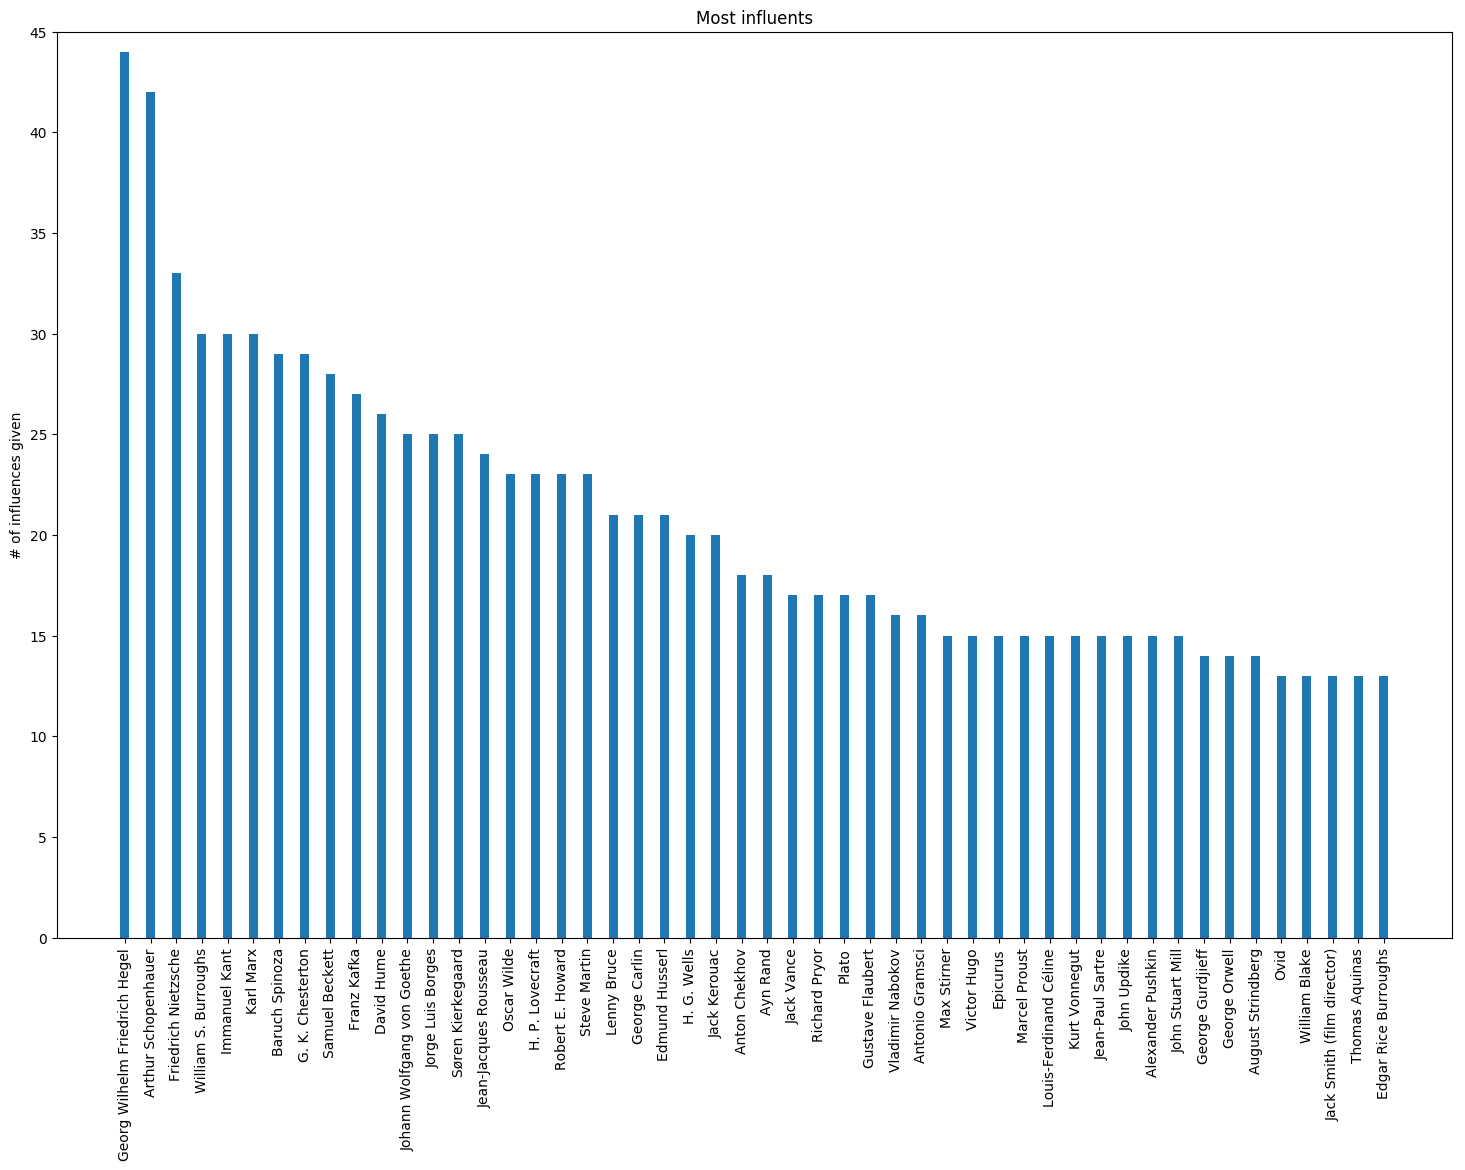

In [10]:
x = np.arange(len(Counter(influences[1:,0]).most_common(50)))
y = list(zip(*Counter(influences[1:,0]).most_common(50)))[1]
labels = list(zip(*Counter(influences[1:,0]).most_common(50)))[0]
y2max = max(y) + 1

plt.figure(figsize=(18,12), dpi=100)
plt.bar(x, y, width=0.35)
plt.xticks(x, labels)
plt.ylim(0, y2max)
plt.xticks(rotation=90)
plt.ylabel('# of influences given')
plt.title('Most influents')

Calculating the Pagerank

In [28]:
pr = nx.pagerank(G.reverse())
pr_sorted = sorted(pr.items(), key=operator.itemgetter(1), reverse=True)
pr_sorted[0:20]

[('Georg Wilhelm Friedrich Hegel', 0.0064561127652033165),
 ('Parmenides', 0.006230684663932356),
 ('Arthur Schopenhauer', 0.005640334066569836),
 ('Democritus', 0.005194423934311061),
 ('Johann Wolfgang von Goethe', 0.004974543368379511),
 ('Heraclitus', 0.004892530720708624),
 ('Plato', 0.0046832068682858335),
 ('Pythagoras', 0.004500821556126092),
 ('Francisco Suárez', 0.004500788454584594),
 ('Jean-Jacques Rousseau', 0.0044662970584633),
 ('Leucippus', 0.0044488608744303266),
 ('Aristotle', 0.004432430646626086),
 ('Baruch Spinoza', 0.004360840037319771),
 ('René Descartes', 0.0040954058400385065),
 ('Pyrrho', 0.004025641995048536),
 ('Hugo Grotius', 0.003948885416504512),
 ('Plotinus', 0.0039052401306109534),
 ('David Hume', 0.003799520073956032),
 ('Immanuel Kant', 0.0037181976601677715),
 ('Maimonides', 0.0036433574233027274)]

In [41]:
bb = nx.betweenness_centrality(G)
bb_sorted = sorted(bb.items(), key=operator.itemgetter(1), reverse=True)
bb_sorted[0:20]

[('Friedrich Nietzsche', 0.0015763617714143739),
 ('Jean-Paul Sartre', 0.0014603027778478767),
 ('Immanuel Kant', 0.0014317506068786607),
 ('Georg Wilhelm Friedrich Hegel', 0.0014195034546051687),
 ('William S. Burroughs', 0.0013268875593367437),
 ('Arthur Schopenhauer', 0.0012259133027170655),
 ('Johann Wolfgang von Goethe', 0.001032827764315951),
 ('Samuel Beckett', 0.0010078169447079537),
 ('Karl Marx', 0.0009474067259988786),
 ('H. P. Lovecraft', 0.0009053435436008169),
 ('Franz Kafka', 0.0007937849100767008),
 ('André Gide', 0.0007711192962060078),
 ('David Hume', 0.0007592098788326779),
 ('Gottfried Leibniz', 0.0007144025161416484),
 ('Albert Camus', 0.0006676373692248016),
 ('Oscar Wilde', 0.0006509056387014186),
 ('Baruch Spinoza', 0.0006220262243874368),
 ('George Orwell', 0.0005961877337707976),
 ('Jorge Luis Borges', 0.0005670518434765213),
 ('Søren Kierkegaard', 0.0005467987530208062)]

In [40]:
nx.set_node_attributes(G, bb, 'betweenness')
nx.set_node_attributes(G, pr, 'pagerank')

print(G.node['David Hume']['betweenness'])

print(G.node['Karl Marx']['pagerank'])

0.0007592098788326789
0.002863534559412418


 2) What are the 10 personalities that were influenced by the most number of people? 

In [11]:
#most_influenced = Counter(influences[1:,1]).most_common(10)
most_influenced = Counter(dict(G.in_degree())).most_common(10)
df_influenced = pd.DataFrame(most_influenced, columns = ['Influenced', '#influences'] )
df_influenced

,Influenced,#influences
0,Friedrich Nietzsche,21
1,Martin Heidegger,20
2,Michel Foucault,19
3,Jean-Paul Sartre,18
4,Stephen King,17
5,Gilles Deleuze,17
6,Georg Wilhelm Friedrich Hegel,16
7,Immanuel Kant,16
8,Bertrand Russell,16
9,Jorge Luis Borges,15


Text(0.5,1,'Most influents')

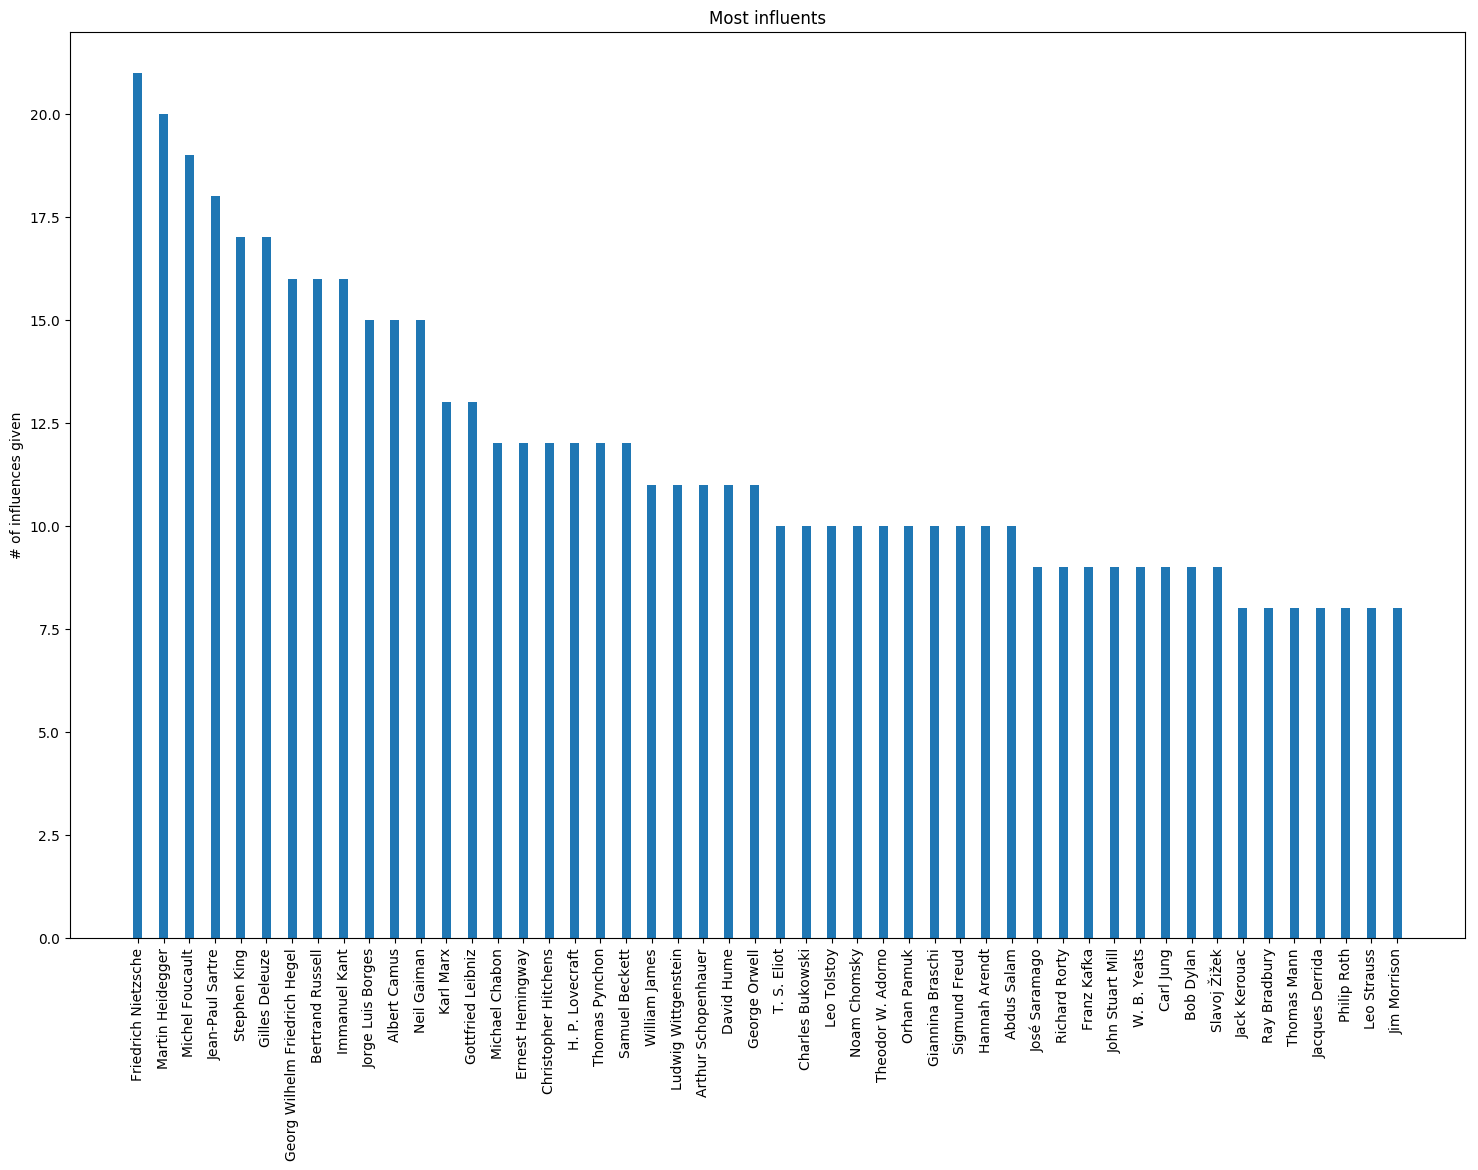

In [12]:
x = np.arange(len(Counter(influences[1:,1]).most_common(50)))
y = list(zip(*Counter(influences[1:,1]).most_common(50)))[1]
labels = list(zip(*Counter(influences[1:,1]).most_common(50)))[0]
y2max = max(y) + 1

plt.figure(figsize=(18,12), dpi=100)
plt.bar(x, y, width=0.35)
plt.xticks(x, labels)
plt.ylim(0, y2max)
plt.xticks(rotation=90)
plt.ylabel('# of influences given')
plt.title('Most influents')

3) What are the 5 major "clusters" of personalities who were influenced by a similar group of the same influencers?   

(Consider a cluster as the group of personalities who were influenced by the same $\tau$ influencers, $\tau$ being an arbitrary number. Start with $\tau$ = 2 and grow until there is no 2 people influenced by all of them.  

4) What are the 5 major influences chains (eg, A -> B -> C -> ...)?

In [13]:
#Shortest path between all nodes
crescent_shortest_paths = nx.all_pairs_shortest_path(G)

paths = []
for key, dictvalue in crescent_shortest_paths:
    for key, value in dictvalue.items():
        paths.append(value)

In [14]:
path_sizes = [len(p) for p in paths]

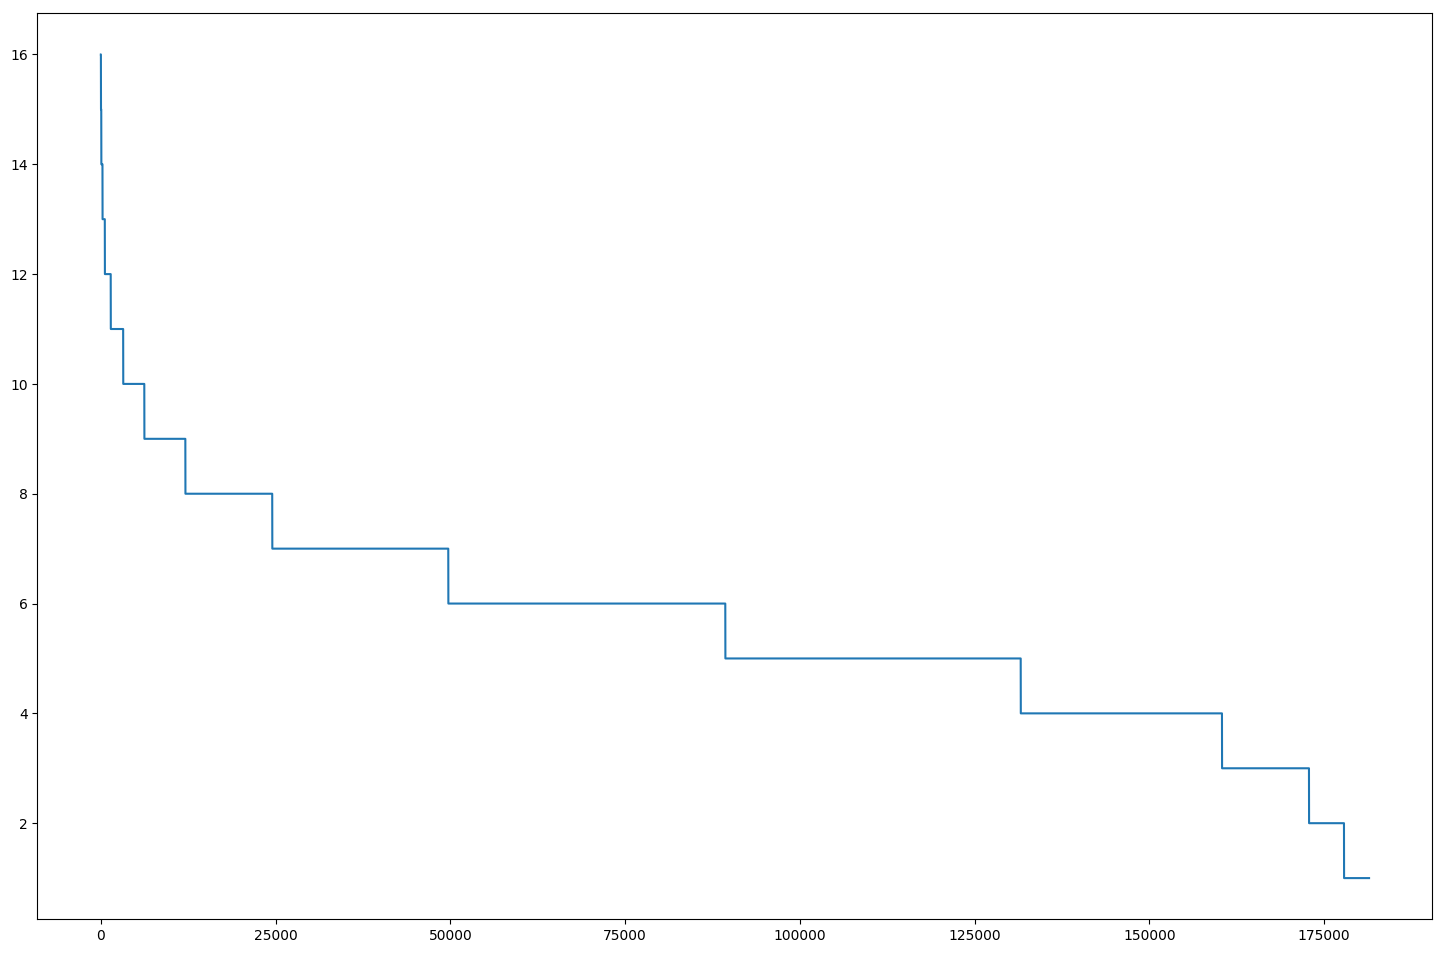

In [15]:
plt.figure(figsize=(18,12), dpi=100)
plt.plot(sorted(path_sizes, reverse=True))

In [16]:
crescent_shortest_paths = nx.all_pairs_shortest_path(G)
longest_paths = []
for key, dictvalue in crescent_shortest_paths:
    for key, value in dictvalue.items():
        if(len(value) > 14):
            longest_paths.append(value)

Path 1: ['Crates of Thebes', 'Zeno of Citium', 'Posidonius', 'Cicero', 'Pierre-Joseph Proudhon', 'Peter Kropotkin', 'Oscar Wilde', 'André Gide', "Brian O'Nolan", 'Spike Milligan', 'Monty Python', 'George Carlin', 'Sam Kinison', 'Larry the Cable Guy', 'Robert Kelly (comedian)']

Path 2: ['Euclid of Megara', 'Stilpo', 'Zeno of Citium', 'Posidonius', 'Cicero', 'Pierre-Joseph Proudhon', 'Peter Kropotkin', 'Oscar Wilde', 'André Gide', "Brian O'Nolan", 'Spike Milligan', 'Monty Python', 'George Carlin', 'Stephen Colbert', 'Rob Corddry']

Path 3: ['Euclid of Megara', 'Stilpo', 'Zeno of Citium', 'Posidonius', 'Cicero', 'Pierre-Joseph Proudhon', 'Peter Kropotkin', 'Oscar Wilde', 'André Gide', "Brian O'Nolan", 'Spike Milligan', 'Monty Python', 'George Carlin', 'Stephen Colbert', 'Aasif Mandvi']

Path 4: ['Euclid of Megara', 'Stilpo', 'Zeno of Citium', 'Posidonius', 'Cicero', 'Pierre-Joseph Proudhon', 'Peter Kropotkin', 'Oscar Wilde', 'André Gide', "Brian O'Nolan", 'Spike Milligan', 'Monty Python'

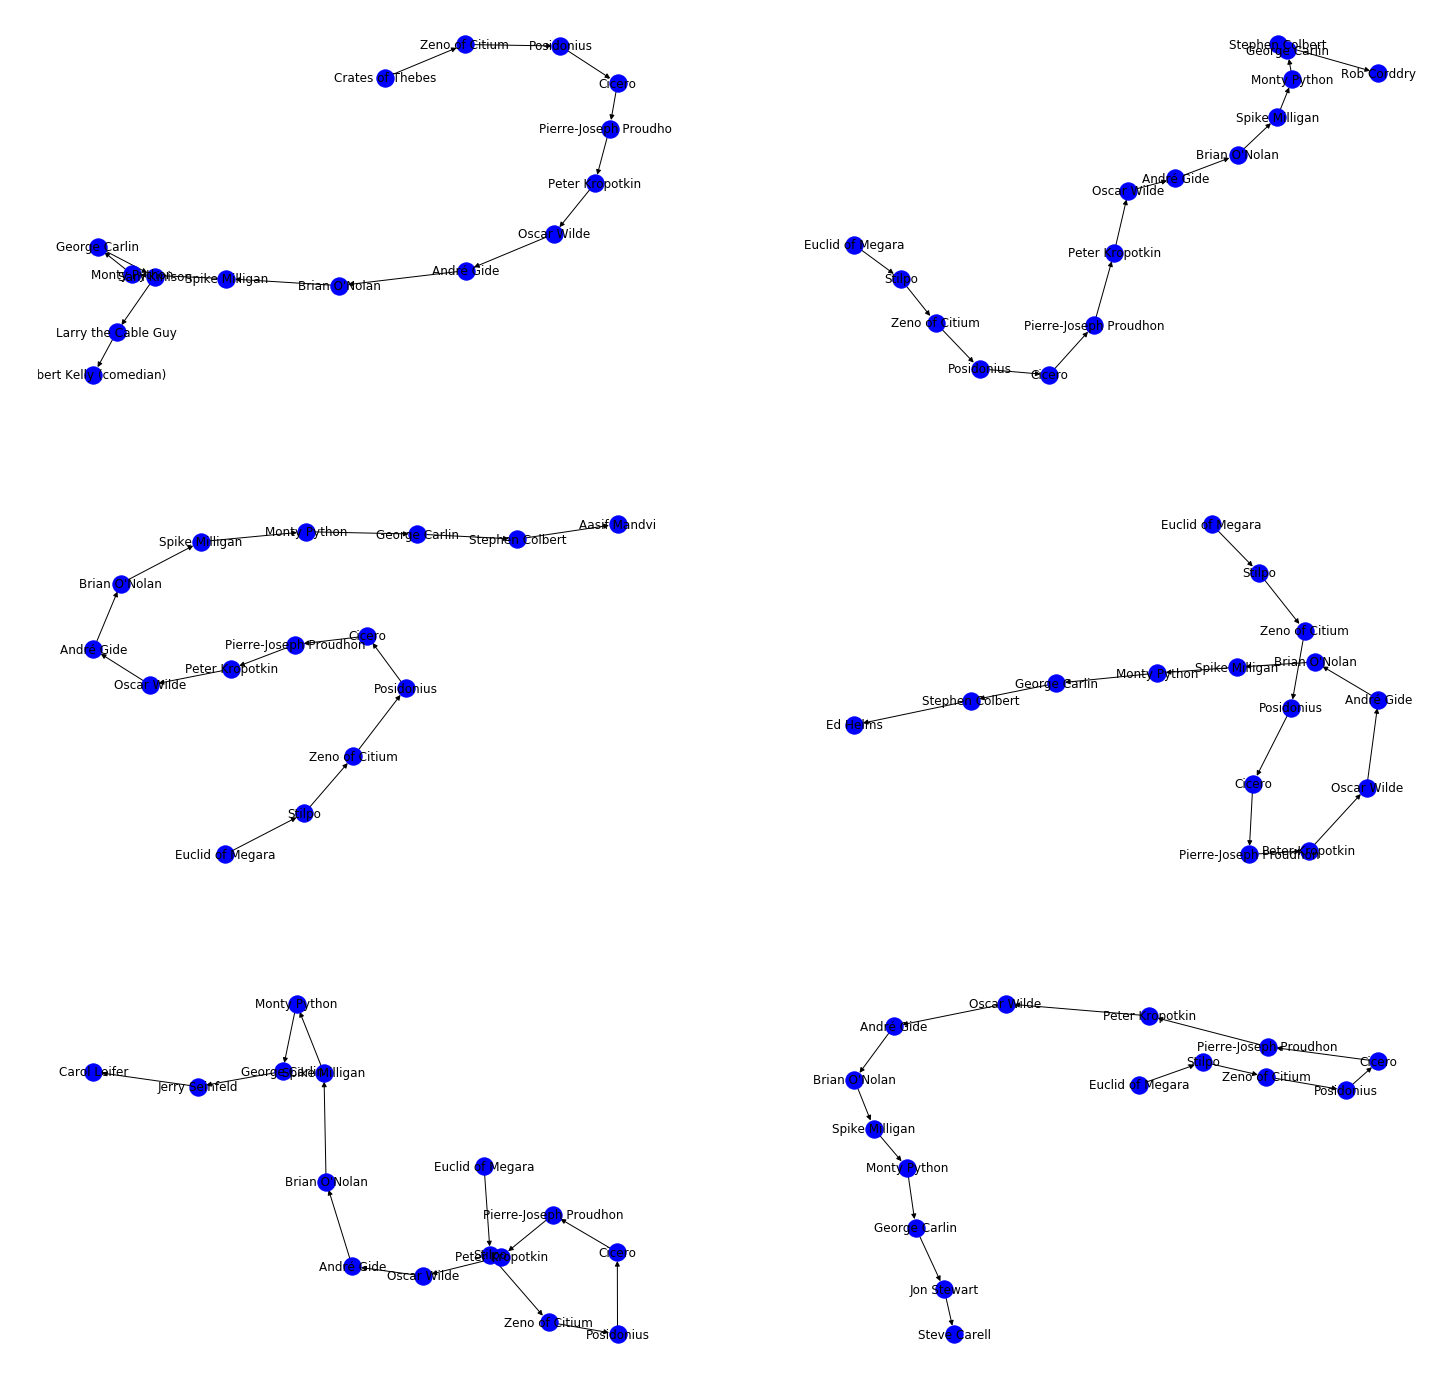

In [17]:
fig = plt.figure(figsize= (25, 25) )
index = 1

for i in longest_paths:
    print("Path " + str(index) + ": " + str(i) + "\n")
    graph = nx.DiGraph()
    graph.add_path(i)
    ax = fig.add_subplot(3,2, index)
    pos = nx.drawing.fruchterman_reingold_layout(graph)
    nx.draw(graph, pos, node_color='blue', with_labels=True) 
    index += 1
    if index > 6:
        break

5) What are the countries that generated the greatest influential? 

In [18]:
#Scraping data from Wikipedia
nationality = []
main_interests = []

for i in range(0,10):
        name = df_influencers.Influencer[i].replace(' ','_')
        url= 'http://pt.wikipedia.org/wiki/' + name
        source = urllib.request.urlopen(url).read()
        soup = BeautifulSoup(source, "lxml")
        information_with_tags = soup.findAll('td')
        information = [t.getText() for t in information_with_tags]
        if 'Nacionalidade' in information:
            nationality_index = information.index('Nacionalidade')
            nationality = nationality + [information[nationality_index +1]]
        else: 
            nationality = nationality + ['Nationality not found']
        if 'Principais Interesses' in information:
            interest_index = information.index('Principais Interesses')
            main_interests = main_interests + ['\\'] +[information[interest_index +1]]
        else: 
            main_interests = main_interests + ['\\'] + ['Interests not found']

In [19]:
for i in range(0,10):
    print('{}\t\t has nationality {}'.format(df_influencers.Influencer[i], nationality[i]))

Georg Wilhelm Friedrich Hegel		 has nationality Alemão
Arthur Schopenhauer		 has nationality  Alemã
Friedrich Nietzsche		 has nationality prussiano
William S. Burroughs		 has nationality  estadunidense
Immanuel Kant		 has nationality Prussiano
Karl Marx		 has nationality alemão
Baruch Spinoza		 has nationality holandesa
G. K. Chesterton		 has nationality Inglesa
Samuel Beckett		 has nationality  Irlandês
Franz Kafka		 has nationality Nationality not found


6) What are the areas of greatest influence? 

In [20]:
for i in range(0,10):
    print('{}\t\t area is {}'.format(df_influencers.Influencer[i], main_interests[i]))

Georg Wilhelm Friedrich Hegel		 area is \
Arthur Schopenhauer		 area is Interests not found
Friedrich Nietzsche		 area is \
William S. Burroughs		 area is Interests not found
Immanuel Kant		 area is \
Karl Marx		 area is Interests not found
Baruch Spinoza		 area is \
G. K. Chesterton		 area is Interests not found
Samuel Beckett		 area is \
Franz Kafka		 area is Interests not found


7) Create a graphical representation of the graph 

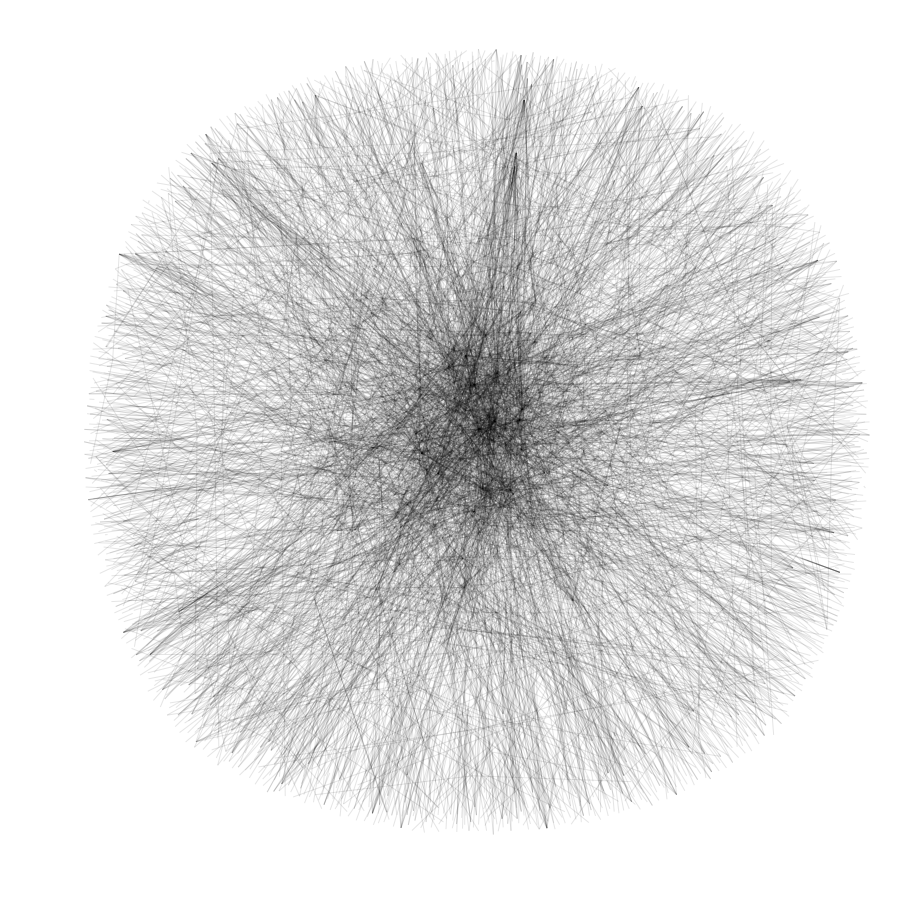

In [21]:
plt.figure(figsize=(12,12))
nx.draw(G, with_labels=False, font_size=False, node_size=False, node_color='r', arrows=False, alpha=0.1)

In [53]:
print("Nodes on graph: " + str(G.number_of_nodes()))
print("Connected components: " + str(nx.number_weakly_connected_components(G)))

Nodes on graph: 3589
Connected components: 414


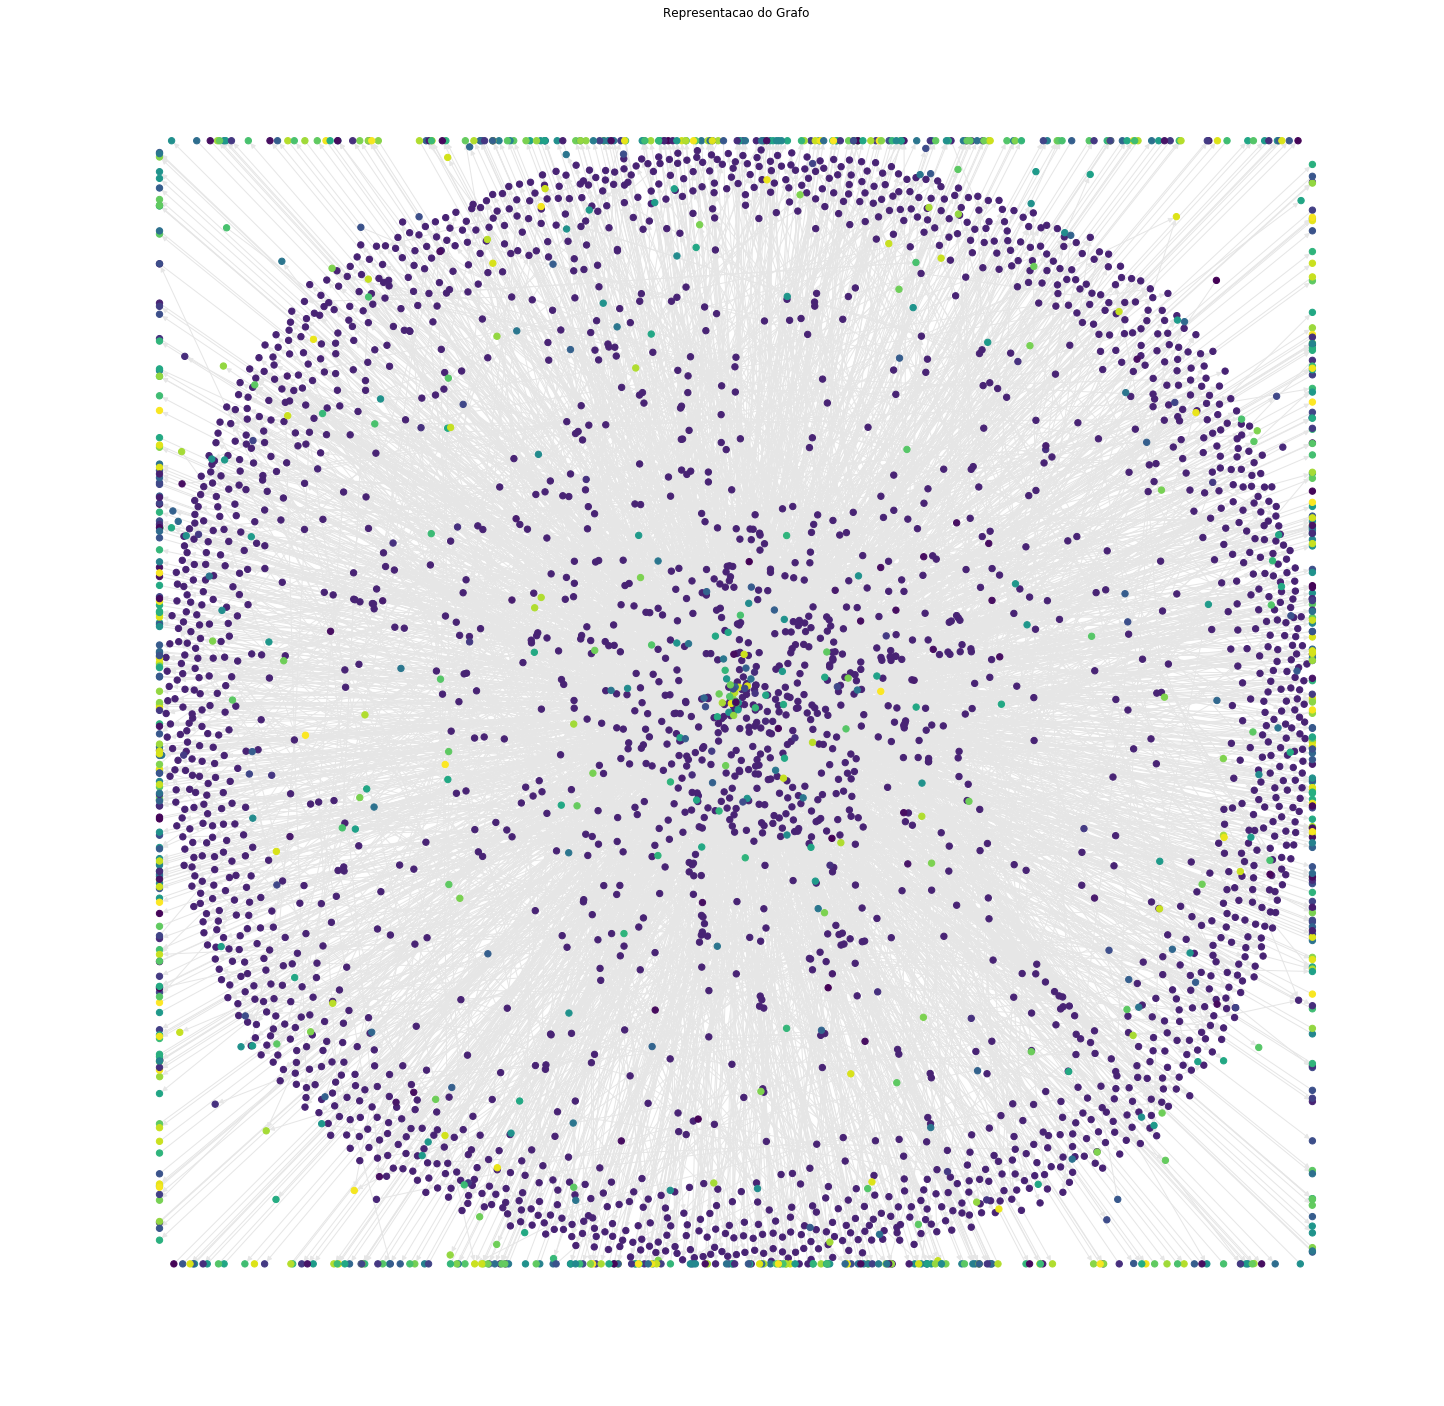

In [54]:
fig = plt.figure(figsize=(25,25))

G2=nx.weakly_connected_component_subgraphs(G)
for g in G2:
    c=[random.random()]*nx.number_of_nodes(g) # random color...
    plt.title('Representacao do Grafo')
    nx.draw_spring(g, node_size=40, node_color=c, edge_color='#E6E6E6', vmin=0.0, vmax=1.0, with_labels=False, edge_cmap=plt.cm.gray )

Exporting to Gephi  
https://gephi.org/users/supported-graph-formats/  